<h2 style="display:inline;"> Turning </h2> 
<img src="img/pymc3.jpg" alt="pymc3_logo" style="width: 200px;display:inline;vertical-align:-200%;"/><br>
<h2 style="display:inline;"> into </h2>
<img src="img/sklearn.png" alt="sklearn_logo" style="width: 150px;display:inline;vertical-align:-150%;"/>
<br><br><br>
<h3>
Nicole Carlson <br><br>
@parsing_science <br><br>
github.com/parsing-science/pydata_nyc_nov_2017
</h3>

About Me
===

<h2 style="display:inline;"> Data Scientist @ </h2><img src="img/sr_logo.jpg" alt="ShopRunner_logo" style="width: 300px;display:inline;vertical-align:-250%;"/><br>

<h2 style="display:inline;"> Instructor @ </h2><img src="img/gwc_logo.jpg" alt="Girls_Who_Code_logo" style="width: 200px;display:inline;vertical-align:-200%;"/><br>

<h2 style="display:inline;"> Physicist @ </h2><img src="img/berkeley_logo.png" alt="Berkeley_logo" style="width: 350px;display:inline;vertical-align:-200%;"/><br>

<h2> Overview </h2>
- <h3 style=font-weight:normal;>Motivating Example: scikit-learn Linear Regression</h3>
- <h3 style=font-weight:normal;>Intro to PyMC3</h3>
- <h3 style=font-weight:normal;>PyMC3 Linear Regression</h3>
- <h3 style=font-weight:normal;>Compare scikit-learn and PyMC3</h3>
- <h3 style=font-weight:normal;>Implement Hierarchical Logistic Regression in PyMC3</h3>
- <h3 style=font-weight:normal;>Use the Hierarchical Logistic Regression</h3>

In [1]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
from pymc3 import summary, traceplot
import pymc3 as pm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import theano
import theano.tensor as T

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [3]:
plt.rcParams['figure.figsize'] = (15, 10)

plt.rcParams['font.size'] = 16

<h2>Motivating Example: scikit-learn</h2>

<h2> Generate Fake Data </h2>

In [4]:
X = np.random.randn(1000, 1)
noise = 2 * np.random.randn(1000, 1)
Y = 4 * X + 3 + noise

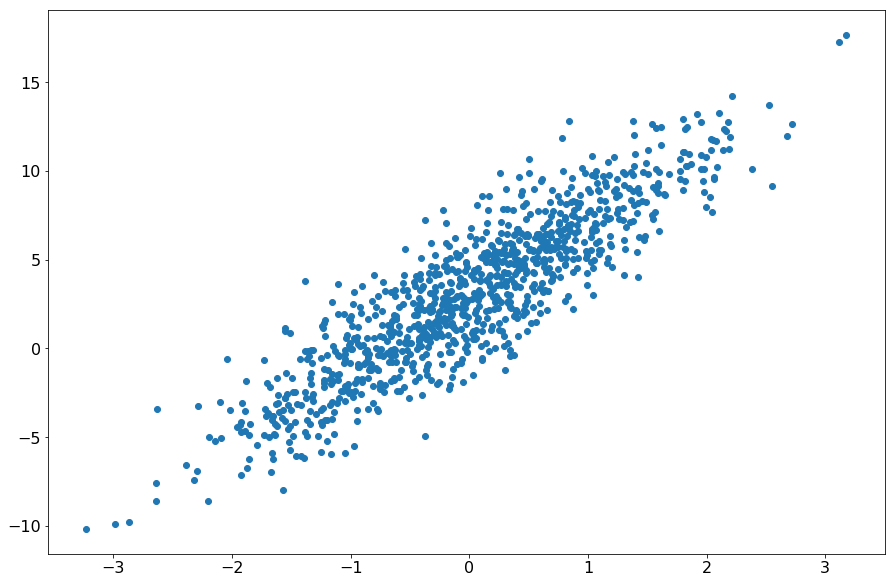

In [5]:
plt.scatter(X, Y)

<h2>Create a LinearRegression instance and use it </h2>

In [6]:
LR = LinearRegression()

In [7]:
LR.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
Y_predict = LR.predict(X)

In [9]:
LR.score(X, Y)

0.79427953408058749

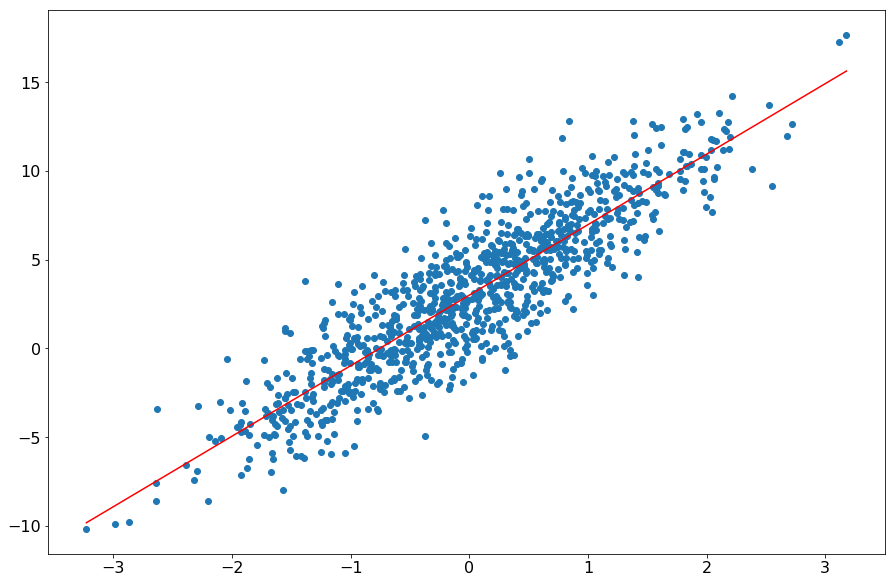

In [10]:
max_x = max(X)
min_x = min(X)

m = LR.coef_[0][0]
b = LR.intercept_[0]
fig1 = plt.figure()
#ax = fig.add_subplot(111)
plt.scatter(X, Y)
plt.plot([min_x, max_x], [m*min_x + b, m*max_x + b], 'r')

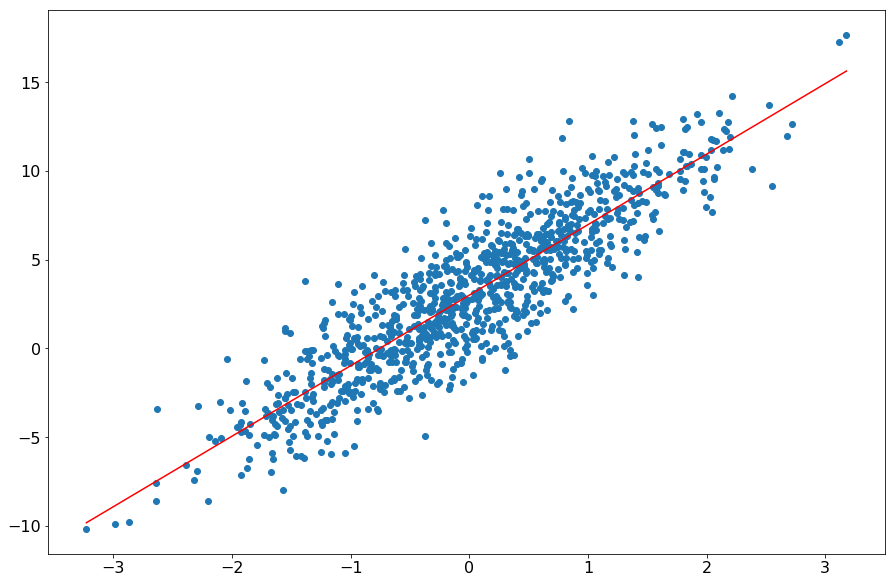

In [11]:
fig1

<h2>Save and Load LR </h2>

In [12]:
pickle.dump(LR, open('LR.pickle', 'wb'))

In [13]:
saved_LR = pickle.load(open('LR.pickle', 'rb'))

In [14]:
saved_LR.score(X, Y)

0.79427953408058749


<h2> Using scikit-learn  </h2>
    
<table>
<tr>
<th> </th>
<th>scikit-learn</th>
<th>PyMC3</th>
</tr>
<tr>
<th>Find model parameters</th>
<th>Easy</th>
<th>?</th>
</tr>
<tr>
<th>Predict new data</th>
<th>Easy</th>
<th>?</th>
</tr>
<tr>
<th>Score a model</th>
<th>Easy</th>
<th>?</th>
</tr>
<tr>
<th>Save a trained model</th>
<th>Easy</th>
<th>?</th>
</tr>
<tr>
<th>Load a trained model</th>
<th>Easy</th>
<th>?</th>
</tr>
</table>


<h2> Intro to PyMC3 </h2>

- <h3 style=font-weight:normal;>Library for Probabilistic Modeling</h3>
- <h3 style=font-weight:normal;>MCMC Samplers</h3>
- <h3 style=font-weight:normal;>Variational Fitting Algorithms</h3>
- <h3 style=font-weight:normal;>Built on top of Theano</h3>
- <h3 style=font-weight:normal;>Completely written in Python</h3>

<h2> Using PyMC3 </h2>
- <p style=color:blue;display:inline;>Step 1: Set up</p> Parameterize your model, choose priors, and insert training data


- <p style=color:blue;display:inline;>Step 2: Inference</p> infer your parameters using MCMC sampling (e.g. NUTS) or variational inference (e.g. ADVI)


- <p style=color:blue;display:inline;>Step 3: Interpret</p> Check your parameter distributions and model fit


- <p style=color:blue;display:inline;>Step 4: Predict data</p> Create posterior samples with your inferred parameters

PyMC3 Linear Regression
===

<h2> Step 1: Set up the PyMC3 model </h2>

In [15]:
lin_reg_model = pm.Model()

model_input = theano.shared(X)

model_output = theano.shared(Y)

with lin_reg_model:

    alpha = pm.Normal('alpha', mu=0, sd=100, shape=(1))
    beta = pm.Normal('beta', mu=0, sd=100, shape=(1))
    
    s = pm.HalfNormal('s', tau=1)
    
    mean = alpha + beta * model_input

    y = pm.Normal('y', mu=mean , sd=s, observed=model_output)

<h2> Step 2: Infer your parameters </h2>

In [16]:
with lin_reg_model:
    inference = pm.ADVI()
    approx = pm.fit(
        n=20000, 
        method=inference, 
        more_replacements={
            model_input: pm.Minibatch(X), 
            model_output: pm.Minibatch(Y)
        }
    )

Average Loss = 287.5: 100%|██████████| 20000/20000 [00:21<00:00, 920.95it/s] 
Finished [100%]: Average Loss = 287.47


Text(0.5,0,'iteration')

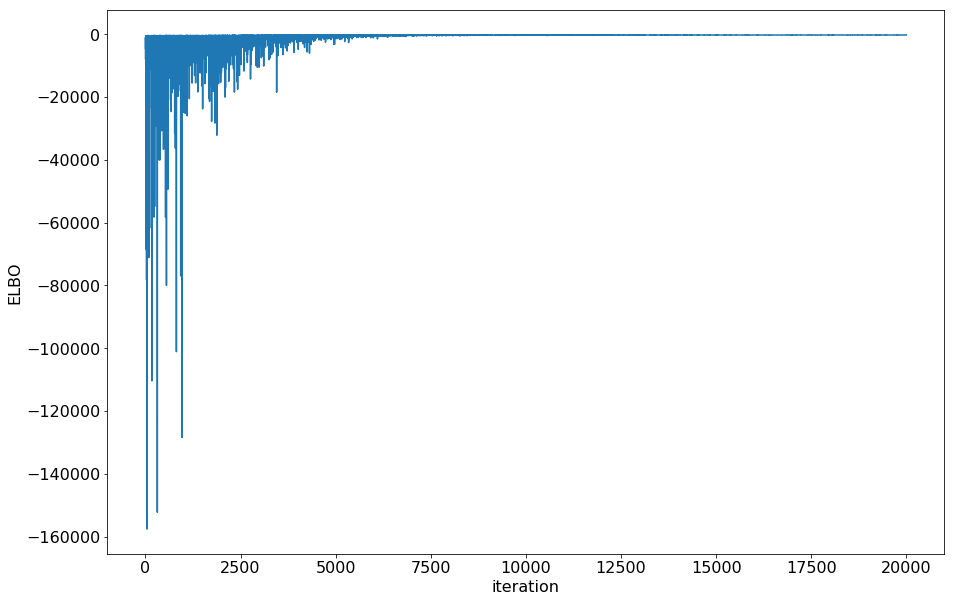

In [17]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration')

<h2> Step 3: Interpret your parameters </h2>

In [18]:
trace = approx.sample(draws=5000)

In [19]:
summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  3.002            0.220            0.003            [2.582, 3.440]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.579          2.851          3.000          3.150          3.440


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  3.968            0.238            0.003            [3.501, 4.423]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  3.502          3.809          3.966          4.129          4.424


s:

  Mean             SD               MC Error         95% HPD interval
  ------------------------------

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e8d0908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10f8b9c50>]], dtype=object)

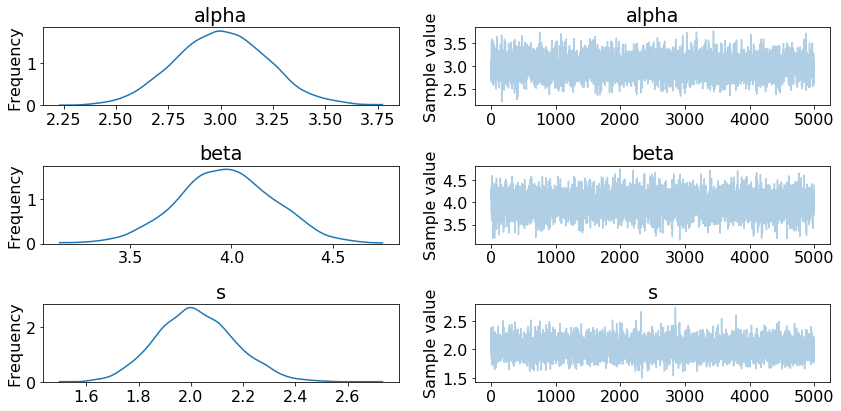

In [20]:
traceplot(trace)

<h2>Step 4: Predict data by creating posterior predictive samples </h2>

In [21]:
ppc = pm.sample_ppc(
    trace[1000:],
    model=lin_reg_model,
    samples=2000
)

100%|██████████| 2000/2000 [00:01<00:00, 1491.51it/s]


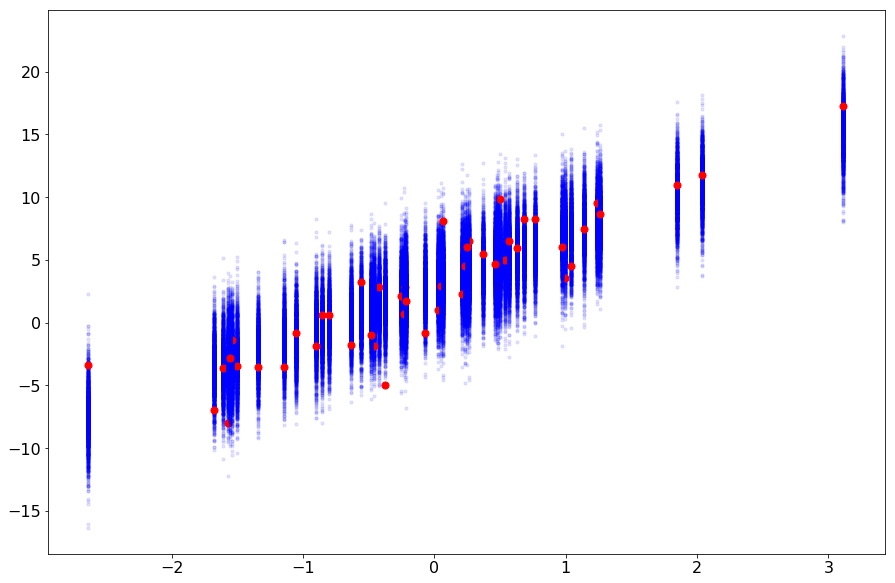

In [22]:
fig2 = plt.figure()
for i in range(50):
    plt.scatter(X[i] * np.ones(len(ppc['y'][:, i])), ppc['y'][:, i], color='b', s=10, alpha=0.1)
    plt.scatter(X[i], Y[i], color='r', s=50)

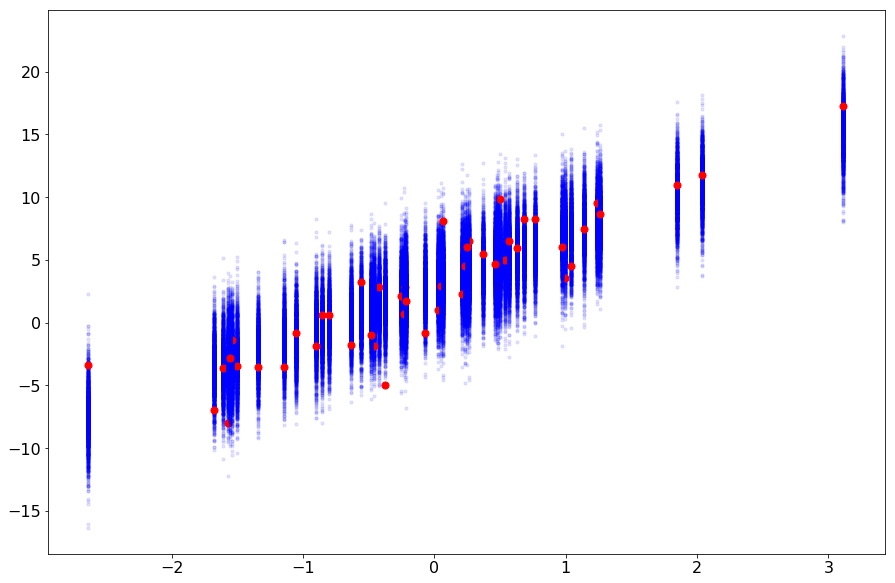

In [23]:
fig2

In [24]:
pred = ppc['y'].mean(axis=0)

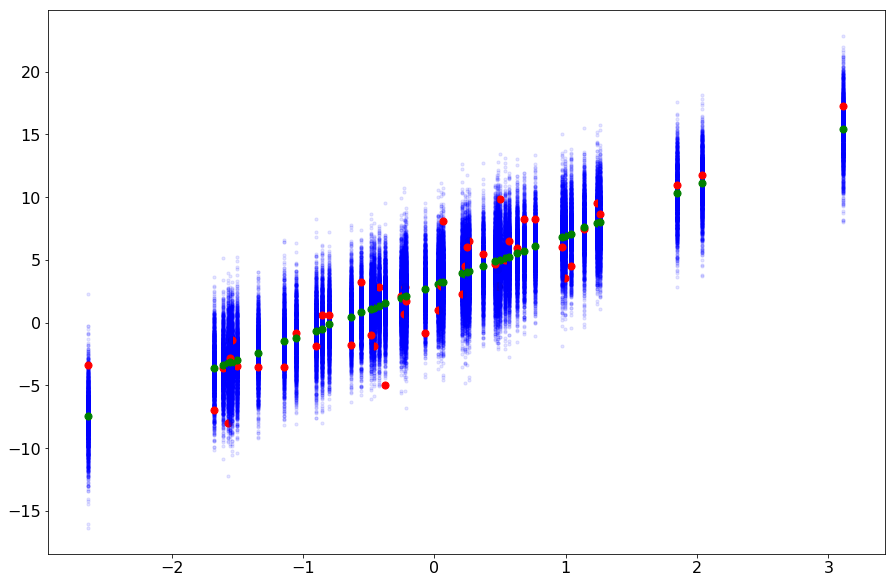

In [25]:
fig3 = plt.figure()
for i in range(50):
    plt.scatter(X[i] * np.ones(len(ppc['y'][:, i])), ppc['y'][:, i], color='b', s=10, alpha=0.1)
    plt.scatter(X[i], Y[i], color='r', s=50)
    plt.scatter(X[i], pred[i], color='g', s=50)

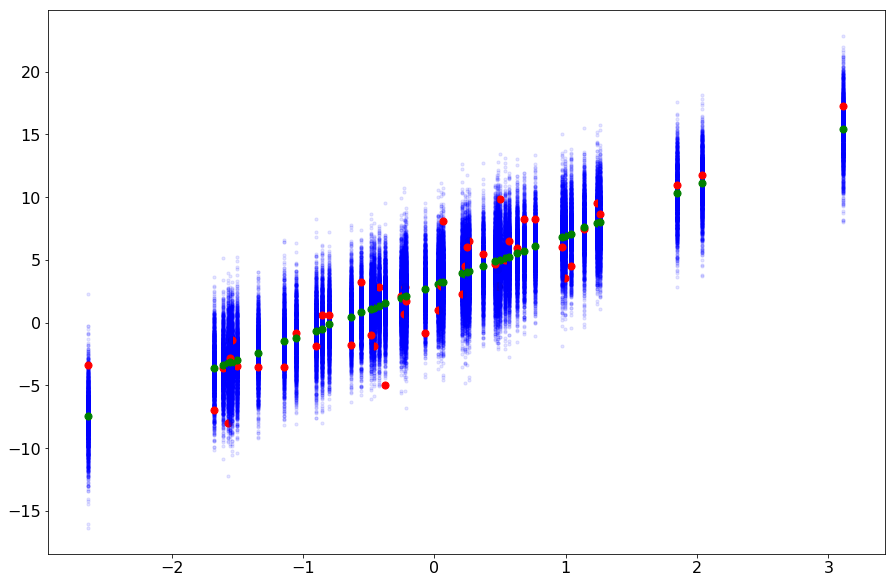

In [26]:
fig3

In [27]:
r2_score(Y, pred)

0.79444136879972738

<h2> Most PyMC3 Examples </h2>

* <h3 style=font-weight:normal;>Exist in Jupyter notebooks</h3>
* <h3 style=font-weight:normal;>Focus on training a model with one dataset</h3>
* <h3 style=font-weight:normal;>Don’t demonstrate how to predict new data</h3>
* <h3 style=font-weight:normal;>Don’t show how to save your model for later use</h3>

<h2> Comparing the two libraries </h2>

<table>
<tr>
<th> </th>
<th>scikit-learn</th>
<th>PyMC3</th>
</tr>
<tr>
<th>Find model parameters</th>
<th>Easy</th>
<th>Medium</th>
</tr>
<tr>
<th>Predict new data</th>
<th>Easy</th>
<th>Difficult</th>
</tr>
<tr>
<th>Score a model</th>
<th>Easy</th>
<th>Difficult</th>
</tr>
<tr>
<th>Save a trained model</th>
<th>Easy</th>
<th>Impossible?</th>
</tr>
<tr>
<th>Load a trained model</th>
<th>Easy</th>
<th>Impossible?</th>
</tr>
</table>


<h2> Comparing the two libraries </h2>

<table>
<tr>
<th> </th>
<th>scikit-learn</th>
<th>PyMC3</th>
</tr>
<tr>
<th>Find model parameters</th>
<th>Easy</th>
<th>Medium</th>
</tr>
<tr>
<th>Predict new data</th>
<th>Easy</th>
<th>Difficult</th>
</tr>
<tr>
<th>Score a model</th>
<th>Easy</th>
<th>Difficult</th>
</tr>
<tr>
<th>Save a trained model</th>
<th>Easy</th>
<th>Impossible?</th>
</tr>
<tr>
<th>Load a trained model</th>
<th>Easy</th>
<th>Impossible?</th>
</tr>
<tr>
<th>Model types</th>
<th>Limited</th>
<th>Broad</th>
</tr>
</table>


<h2> What we want to reproduce in PyMC3 </h2>

* <h3 style=font-weight:normal;>fit</h3>
* <h3 style=font-weight:normal;>predict</h3>
* <h3 style=font-weight:normal;>score</h3>
* <h3 style=font-weight:normal;>save</h3>
* <h3 style=font-weight:normal;>load</h3>


<h2> Map between scikit-learn and PyMC3 </h2>

<table>
<tr>
<th>scikit-learn</th>
<th>PyMC3</th>
</tr>
<tr>
<th>Fit</th>
<th>Step 1: Set up, Step 2: Inference</th>
</tr>
<tr>
<th>Predict</th>
<th>Step 4: Predict data</th>
</tr>
<tr>
<th>Score</th>
<th>Step 4: Predict data</th>
</tr>
<tr>
<th>Save/Load</th>
<th>??</th>
</tr>
<tr>
<th>??</th>
<th>Step 3: Interpret</th>
</tr>
</table>

Implement Hierarchical Logistic Regression
===

Create a BayesianModel Base Class for reusable components
===

Methods implemented in base class
===

- <h3 style=font-weight:normal;>_inference</h3>
- <h3 style=font-weight:normal;>_set_shared_values</h3>

Methods to be implemented by child class:
===

- <h3 style=font-weight:normal;>create_model</h3>
- <h3 style=font-weight:normal;>fit</h3>
- <h3 style=font-weight:normal;>predict</h3>
- <h3 style=font-weight:normal;>score</h3>

<h2> Initializing the HLR class </h2>

In [ ]:
class HLR(BayesianModel):
    """
    Custom Hierarchical Logistic Regression built using PyMC3.
    """

    def __init__(self):
        super(HLR, self).__init__() # <- Base class method
        self.num_cats = None

In [ ]:
class BayesianModel(BaseEstimator):
    """
    Bayesian model base class
    """
    def __init__(self):
        self.advi_hist = None
        self.advi_trace = None
        self.cached_model = None
        self.num_pred = None
        self.shared_vars = None

<h2> Fit </h2>

In [ ]:
def fit(self, X, y, cats, n=200000, batch_size=100): # <- HLR method
    """
    Train the HLM model

    Parameters
    ----------
    X : numpy array, shape [n_samples, n_features]

    y : numpy array, shape [n_samples, ]

    cats: numpy array, shape [n_samples, ]

    n: number of iterations for ADVI fit, defaults to 200000

    batch_size: number of samples to include in each minibatch for ADVI, defaults to 100
    """
    self.num_cats = len(np.unique(cats))
    num_samples, self.num_pred = X.shape

    if self.cached_model is None:
        self.cached_model = self.create_model() # <- HLR method

    with self.cached_model:

        minibatches = {
            self.shared_vars['model_input']: pm.Minibatch(
                X, 
                batch_size=batch_size
            ),
            self.shared_vars['model_output']: pm.Minibatch(
                y, 
                batch_size=batch_size
            ),
            self.shared_vars['model_cats']: pm.Minibatch(
                cats, 
                batch_size=batch_size
            )
        }

        self._inference(minibatches, n) # <- Base class method

    return self

<h2> Step 1: Set up the model </h2>

In [ ]:
def create_model(self): # <- HLR method
    """
    Creates and returns the PyMC3 model.

    Returns the model.
    """
    model_input = theano.shared(np.zeros([1, self.num_pred]))

    model_output = theano.shared(np.zeros(1))

    model_cats = theano.shared(np.zeros(1, dtype='int'))

    self.shared_vars = {
        'model_input': model_input,
        'model_output': model_output,
        'model_cats': model_cats
    }

    model = pm.Model()

    with model:
        mu_alpha = pm.Normal('mu_alpha', mu=0, sd=100)
        sigma_alpha = pm.HalfNormal('sigma_alpha', sd=100)

        mu_beta = pm.Normal('mu_beta', mu=0, sd=100)
        sigma_beta = pm.HalfNormal('sigma_beta', sd=100)

        alpha = pm.Normal(
            'alpha', 
            mu=mu_alpha, 
            sd=sigma_alpha, 
            shape=(self.num_cats,)
        )
        beta = pm.Normal(
            'beta', 
            mu=mu_beta, 
            sd=sigma_beta, 
            shape=(self.num_cats, self.num_pred)
        )

        c = model_cats

        temp = alpha[c] + T.sum(beta[c] * model_input, 1)

        p = pm.invlogit(temp)

        o = pm.Bernoulli('o', p, observed=model_output)

    return model


<h2> Step 2: Inference (Base class method) </h2>

In [ ]:
def _inference(self, minibatches, n=200000): # <- Base class method
    """
    Runs minibatch variational ADVI and then sample from those results.

    Parameters
    ----------
    minibatches: minibatches for ADVI

    n: number of iterations for ADVI fit, defaults to 200000
    """
    with self.cached_model:
        advi = pm.ADVI()
        approx = pm.fit(
            n=n,
            method=advi,
            more_replacements=minibatches,
            callbacks=[pm.callbacks.CheckParametersConvergence()]
        )

    self.advi_trace = approx.sample(draws=10000)

    self.advi_hist = advi.hist

<h2> Predict Probabilities </h2>

In [ ]:
def predict_proba(self, X, cats, return_std=False): # <- HLR method
    """
    Predicts probabilities of new data with a trained HLR

    Parameters
    ----------
    X : numpy array, shape [n_samples, n_features]

    cats: numpy array, shape [n_samples, ]

    return_std: Boolean flag of whether to return standard deviations with mean probabilities. Defaults to False.
    """

    if self.advi_trace is None:
        raise PSToolkitError('Run fit on the model before predict.')

    num_samples = X.shape[0]

    if self.cached_model is None:
        self.cached_model = self.create_model()

    self._set_shared_vars({
        'model_input': X, 
        'model_output': np.zeros(num_samples), 
        'model_cats': cats
    })

    ppc = pm.sample_ppc(self.advi_trace, model=self.cached_model, samples=2000)

    if return_std:
        return ppc['o'].mean(axis=0), ppc['o'].std(axis=0)
    else:
        return ppc['o'].mean(axis=0)

<h2> Predict </h2>

In [ ]:
def predict(self, X, cats): # <- HLR method
    """
    Predicts labels of new data with a trained model

    Parameters
    ----------
    X : numpy array, shape [n_samples, n_features]

    cats: numpy array, shape [n_samples, ]
    """
    ppc_mean = self.predict_proba(X, cats)

    pred = ppc_mean > 0.5

    return pred

<h2> Score </h2>

In [ ]:
def score(self, X, y, cats): # <- HLR method
    """
    Scores new data with a trained model.

    Parameters
    ----------
    X : numpy array, shape [n_samples, n_features]

    y : numpy array, shape [n_samples, ]

    cats: numpy array, shape [n_samples, ]
    """

    return accuracy_score(y, self.predict(X, cats))

<h2> Save </h2>

In [ ]:
def save(self, file_prefix): # <- HLR method
    params = {'num_cats': self.num_cats, 'num_pred': self.num_pred}

    super(HLR, self).save(file_prefix, params) # <- Base class method

In [ ]:
def save(self, file_prefix, custom_params=None): # <- Base class method
    """
    Saves the advi_trace and custom params to files with the given file_prefix.

    Parameters
    ----------
    file_prefix: str, path and prefix used to identify where to save the trace for this model.
    Ex: given file_prefix = "path/to/file/"
    This will attempt to save to "path/to/file/advi_trace.pickle"

    custom_params: Dictionary of custom parameters to save. Defaults to None
    """
    fileObject = open(file_prefix + 'advi_trace.pickle', 'wb')
    joblib.dump(self.advi_trace, fileObject)
    fileObject.close()

    if custom_params:
        fileObject = open(file_prefix + 'params.pickle', 'wb')
        joblib.dump(custom_params, fileObject)
        fileObject.close()

<h2> Load </h2>

In [ ]:
def load(self, file_prefix): # <- HLR method
    params = super(HLR, self).load(file_prefix, load_custom_params=True) # <- Base class method

    self.num_cats = params['num_cats']
    self.num_pred = params['num_pred']

In [ ]:
def load(self, file_prefix, load_custom_params=False): # <- Base class method
    """
    Loads a saved version of the advi_trace, v_params, and custom param files with the given file_prefix.

    Parameters
    ----------
    file_prefix: str, path and prefix used to identify where to load the saved trace for this model.
    Ex: given file_prefix = "path/to/file/"
    This will attempt to load "path/to/file/advi_trace.pickle"

    load_custom_params: Boolean flag to indicate whether custom parameters should be loaded. Defaults to False.

    Returns
    ----------
    custom_params: Dictionary of custom parameters
    """
    self.advi_trace = joblib.load(file_prefix + 'advi_trace.pickle')

    custom_params = None
    if load_custom_params:
        custom_params = joblib.load(file_prefix + 'params.pickle')

    return custom_params

<h2>Use the Hierarchical Logistic Regression class </h2>

<h2> Generate Fake Data </h2>

In [28]:
num_pred = 2
num_samples = 70000
num_categories = 2

In [29]:
# mu_alpha = sigma_alpha = 5
alphas = 5 * np.random.randn(num_categories) + 5 

# mu_beta = sigma_beta = 10
betas = 10 * np.random.randn(num_categories, num_pred) + 10 

In [30]:
alphas

array([ 11.90709046,   7.16916242])

In [31]:
betas

array([[ 22.82384321,  13.76736345],
       [ 18.53762592,   2.25306798]])

In [32]:
def numpy_invlogit(x):
    return 1 / (1 + np.exp(-x))

In [33]:
x_a = np.random.randn(num_samples, num_pred)
y_a = np.random.binomial(
    1, 
    numpy_invlogit(alphas[0] + np.sum(betas[0] * x_a, 1))
)
x_b = np.random.randn(num_samples, num_pred)
y_b = np.random.binomial(
    1, 
    numpy_invlogit(alphas[1] + np.sum(betas[1] * x_b, 1))
)

X = np.concatenate([x_a, x_b])
Y = np.concatenate([y_a, y_b])
cats = np.concatenate([
    np.zeros(num_samples, dtype=np.int),
    np.ones(num_samples, dtype=np.int)
])

<h2> Load the class </h2>

In [34]:
from ps_toolkit import HLR

In [35]:
HLR1 = HLR()

In [36]:
warnings.filterwarnings(action="ignore", module="theano", message="^theano.tensor.round")

<h2> Fit the HLR </h2>

In [37]:
HLR1.fit(X, Y, cats, n=350000, batch_size=2000)

Average Loss = 144.44: 100%|██████████| 350000/350000 [11:28<00:00, 508.71it/s]
Finished [100%]: Average Loss = 144.49


HLR()

<h2> Predict and score the model </h2>

In [38]:
probs = HLR1.predict_proba(X, cats)

100%|██████████| 2000/2000 [00:30<00:00, 66.46it/s]


In [39]:
pred = HLR1.predict(X, cats)

100%|██████████| 2000/2000 [00:25<00:00, 78.15it/s]


In [40]:
HLR1.score(X, Y, cats)

100%|██████████| 2000/2000 [00:26<00:00, 74.30it/s]


0.97660000000000002

<h2> Save and Load the model </h2>

In [41]:
HLR1.save('HLR_jar/')

In [42]:
HLR2 = HLR()

In [43]:
HLR2.load('HLR_jar/')

In [44]:
HLR2.score(X, Y, cats)

100%|██████████| 2000/2000 [00:26<00:00, 75.31it/s]


0.97646428571428567

<h2>Step 3: Interpret your parameters</h2>

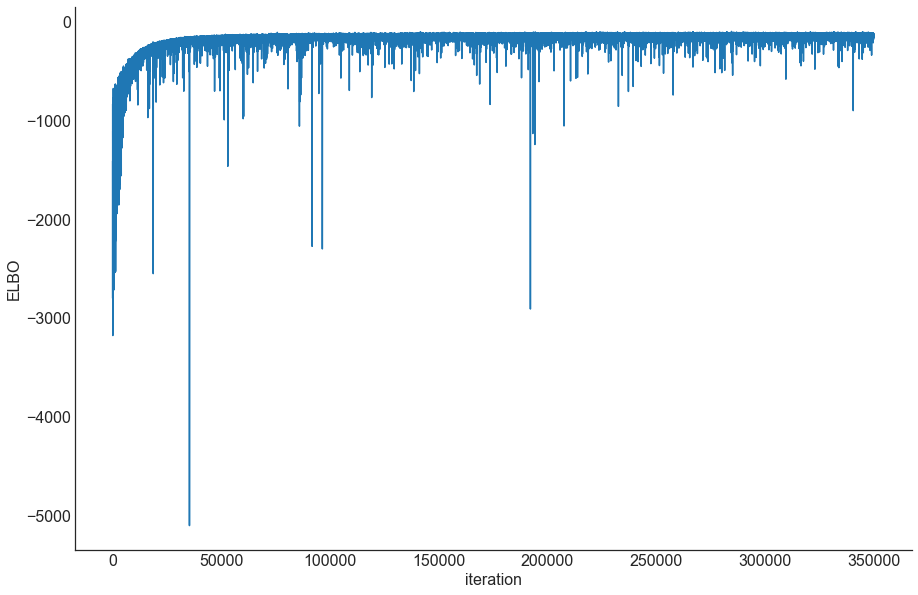

In [45]:
HLR1.plot_elbo()

In [46]:
summary(HLR1.advi_trace)


mu_alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  8.612            5.280            0.052            [-2.285, 18.436]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -1.827         5.114          8.597          12.176         19.033


mu_beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  13.057           5.528            0.047            [2.631, 24.133]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.351          9.368          13.035         16.777         23.907


alpha:

  Mean             SD               MC Error         95% HPD interval
  ---------------

In [47]:
alphas

array([ 11.90709046,   7.16916242])

In [48]:
betas

array([[ 22.82384321,  13.76736345],
       [ 18.53762592,   2.25306798]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11769da90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112c7c4e0>]], dtype=object)

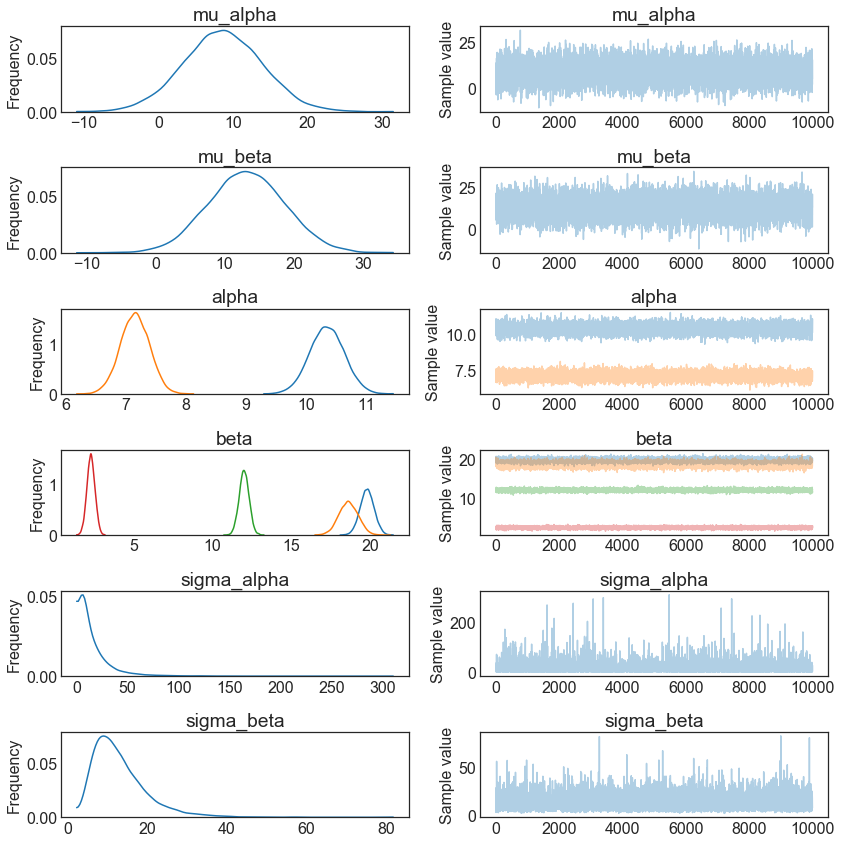

In [49]:
traceplot(HLR1.advi_trace)

<h2> Comparing scitkit-learn, PyMC3, and my custom class </h2>

<table>
<tr>
<th> </th>
<th>scikit-learn</th>
<th>PyMC3</th>
<th>My custom class</th>
</tr>
<tr>
<th>Find model parameters</th>
<th>Easy</th>
<th>Medium</th>
<th>Easy</th>
</tr>
<tr>
<th>Predict new data</th>
<th>Easy</th>
<th>Difficult</th>
<th>Easy</th>
</tr>
<tr>
<th>Score a model</th>
<th>Easy</th>
<th>Difficult</th>
<th>Easy</th>
</tr>
<tr>
<th>Save a trained model</th>
<th>Easy</th>
<th>Impossible?</th>
<th>Easy</th>
</tr>
<tr>
<th>Load a trained model</th>
<th>Easy</th>
<th>Impossible?</th>
<th>Easy</th>
</tr>
<tr>
<th>Interpret Parameterization</th>
<th>N/A</th>
<th>Easy</th>
<th>Easy</th>
</tr>
</table>


<h2> Next Steps </h2>

* <h3 style=font-weight:normal;>Pass more options to the various methods</h3>
* <h3 style=font-weight:normal;>Implement more types of inference</h3>
* <h3 style=font-weight:normal;>Test if this class can be used in an sklearn pipeline</h3>


<h2> Thanks: </h2>
- <h3 style=font-weight:normal;>My coworkers at ShopRunner (we're hiring!)</h3>
- <h3 style=font-weight:normal;>My former coworkers at Shiftgig: Daniel Little, Tudor Radoaca, Nico Sandller</h3>
- <h3 style=font-weight:normal;>PyData Chicago</h3>

<h4>
@parsing_science<br><br>
Slides: github.com/parsing-science/pydata_nyc_nov_2017<br><br>
Code: github.com/parsing-science/ps-toolkit
</h4>